# Stacked Bi-LSTM iter 1 
Here we train for a length of 100 units
Where the change is done in creating the list of patients
Note: Here patients is list of Control subjects and patients1 is list of Parkinson patients

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import utils as np_utils

from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For wider plots
plt.rcParams["figure.figsize"] = (20,6)

# Take my NVidia GPU into use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [3]:
files1 = glob.glob("./parkinsons/*Co*.txt")
files2 = glob.glob("./parkinsons/*Pt*.txt")
# files=files1+files2
# shuffle(files)

In [4]:
columns = ["elaps_time","L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]

In [5]:
def getClassForHealthyOrNot(filename):
    if (filename.find("Co") >=0):
        return 0
    else:
        return 1


In [6]:
class Patient:
    def __init__(self,input_data,y):
        self.x = input_data
        self.y = y
        self.x_scaled = input_data

In [7]:
patients=[]
un_used_data=[]

for f in files1:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+101,:]
        
        if data.shape[0] == 100:
            patients.append( Patient(data, ispark) )
        
        j=j+50

In [8]:
patients1=[]
un_used_data1=[]

for f in files2:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+101,:]
        
        if data.shape[0] == 100:
            patients1.append( Patient(data, ispark) )
        
        j=j+50

In [9]:
len(patients)

20126

In [10]:
len(patients1)


44667

In [11]:
shuffle(patients)
shuffle(patients1)

In [12]:
train = patients[:int(len(patients)*0.8)]+patients1[:int(len(patients1)*0.8)]
test = patients[int(len(patients)*0.8):]+patients1[int(len(patients1)*0.8):]

In [13]:
print(len(train))
print(len(test))

51833
12960


In [14]:
shuffle(train)
shuffle(test)

In [15]:
train_concat=[]
for p in train:
    train_concat = train_concat+[p.x]

In [16]:
data_tr = pd.concat(train_concat,ignore_index=True)

In [17]:
scaler = StandardScaler()
scaler.fit_transform(data_tr)

array([[-0.57097252, -0.6756223 , -0.64615153, ...,  0.042079  ,
        -1.10412961,  0.71590061],
       [-0.43184923, -0.6756223 , -0.64615153, ...,  0.042079  ,
        -1.06822336,  0.64935213],
       [ 0.17628822, -0.6756223 , -0.64615153, ...,  0.042079  ,
        -0.91126952,  0.58171269],
       ...,
       [ 2.10925887,  2.33753231,  0.55731202, ...,  1.28951148,
         0.76734775, -0.07368075],
       [ 2.03653533,  2.33753231,  0.5892881 , ...,  1.10069942,
         0.83508   , -0.29105427],
       [ 1.98699901,  2.36301354,  0.5892881 , ...,  0.81642059,
         0.90335628, -0.47460807]])

In [18]:
i=0
wo_time_col=["L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]
for obj in train:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [19]:
for obj in test:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [20]:
X_scaled_list_train=[]
Y_list_train=[]

for obj in train:
    X_scaled_list_train = X_scaled_list_train + [obj.x_scaled]
    Y_list_train = Y_list_train + [obj.y]
    
X_scaled_arr_train = np.array(X_scaled_list_train)
Y_arr_train = np.array(Y_list_train)

In [21]:
X_scaled_arr_train.shape

(51833, 100, 18)

In [62]:
Y_arr_train.shape

(51833,)

In [22]:
X_scaled_list_test=[]
Y_list_test=[]

for obj in test:
    X_scaled_list_test = X_scaled_list_test + [obj.x_scaled]
    Y_list_test = Y_list_test + [obj.y]
    
X_scaled_arr_test = np.array(X_scaled_list_test)
Y_arr_test = np.array(Y_list_test)

In [23]:
import numpy as np

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(80, dropout=0.3, 
                  return_sequences=True, 
                  input_shape=(X_scaled_arr_train.shape[1], X_scaled_arr_train.shape[2]))))
model.add(Bidirectional(LSTM(32, dropout=0.5,return_sequences=True)))
model.add(LSTM(24, dropout=0.2,return_sequences=True))
model.add(LSTM(12, dropout=0.2,return_sequences=False))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='relu'))
opt=tf.keras.optimizers.Adam(
    learning_rate=0.00005,
    name="Adam"
    )
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./Model/model_LSTM22.v", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False)

In [44]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.2,batch_size=34,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
1220/1220 [==============================] - 39s 32ms/step - loss: 0.8556 - accuracy: 0.6353 - val_loss: 0.7126 - val_accuracy: 0.6360

Epoch 00001: val_accuracy did not improve from 0.74467
Epoch 2/500
1220/1220 [==============================] - 48s 39ms/step - loss: 0.6665 - accuracy: 0.6569 - val_loss: 0.5565 - val_accuracy: 0.7183

Epoch 00002: val_accuracy did not improve from 0.74467
Epoch 3/500
1220/1220 [==============================] - 48s 39ms/step - loss: 0.5612 - accuracy: 0.7186 - val_loss: 0.4973 - val_accuracy: 0.7683

Epoch 00003: val_accuracy improved from 0.74467 to 0.76830, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 4/500
1220/1220 [==============================] - 42s 34ms/step - loss: 0.5167 - accuracy: 0.7563 - val_loss: 0.4673 - val_accuracy: 0.7917

Epoch 00004: val_accuracy improved from 0.76830 to 0.79174, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 5/500
1220/1220 [==============================] - 53s 43ms/step - loss: 0.4901 - accuracy: 0.7816 - val_loss: 0.4409 - val_accuracy: 0.8146

Epoch 00005: val_accuracy improved from 0.79174 to 0.81460, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 6/500
1220/1220 [==============================] - 43s 35ms/step - loss: 0.4673 - accuracy: 0.7983 - val_loss: 0.4168 - val_accuracy: 0.8300

Epoch 00006: val_accuracy improved from 0.81460 to 0.83004, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 7/500
1220/1220 [==============================] - 44s 36ms/step - loss: 0.4506 - accuracy: 0.8092 - val_loss: 0.3949 - val_accuracy: 0.8391

Epoch 00007: val_accuracy improved from 0.83004 to 0.83910, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 8/500
1220/1220 [==============================] - 50s 41ms/step - loss: 0.4333 - accuracy: 0.8191 - val_loss: 0.3675 - val_accuracy: 0.8514

Epoch 00008: val_accuracy improved from 0.83910 to 0.85136, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 9/500
1220/1220 [==============================] - 42s 34ms/step - loss: 0.4186 - accuracy: 0.8289 - val_loss: 0.3461 - val_accuracy: 0.8645

Epoch 00009: val_accuracy improved from 0.85136 to 0.86447, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 10/500
1220/1220 [==============================] - 44s 36ms/step - loss: 0.4011 - accuracy: 0.8379 - val_loss: 0.3682 - val_accuracy: 0.8537

Epoch 00010: val_accuracy did not improve from 0.86447
Epoch 11/500
1220/1220 [==============================] - 47s 38ms/step - loss: 0.4042 - accuracy: 0.8388 - val_loss: 0.3161 - val_accuracy: 0.8783

Epoch 00011: val_accuracy improved from 0.86447 to 0.87827, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 12/500
1220/1220 [==============================] - 42s 34ms/step - loss: 0.3682 - accuracy: 0.8574 - val_loss: 0.2964 - val_accuracy: 0.8886

Epoch 00012: val_accuracy improved from 0.87827 to 0.88859, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 13/500
1220/1220 [==============================] - 46s 38ms/step - loss: 0.3522 - accuracy: 0.8677 - val_loss: 0.2795 - val_accuracy: 0.9008

Epoch 00013: val_accuracy improved from 0.88859 to 0.90084, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 14/500
1220/1220 [==============================] - 47s 39ms/step - loss: 0.3257 - accuracy: 0.8811 - val_loss: 0.2707 - val_accuracy: 0.8991

Epoch 00014: val_accuracy did not improve from 0.90084
Epoch 15/500
1220/1220 [==============================] - 44s 36ms/step - loss: 0.3372 - accuracy: 0.8756 - val_loss: 0.2457 - val_accuracy: 0.9126

Epoch 00015: val_accuracy improved from 0.90084 to 0.91261, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 16/500
1220/1220 [==============================] - 41s 34ms/step - loss: 0.3034 - accuracy: 0.8908 - val_loss: 0.2613 - val_accuracy: 0.9180

Epoch 00016: val_accuracy improved from 0.91261 to 0.91801, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 17/500
1220/1220 [==============================] - 43s 35ms/step - loss: 0.2992 - accuracy: 0.8912 - val_loss: 0.2835 - val_accuracy: 0.9188

Epoch 00017: val_accuracy improved from 0.91801 to 0.91878, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 18/500
1220/1220 [==============================] - 45s 37ms/step - loss: 0.2789 - accuracy: 0.9044 - val_loss: 0.3422 - val_accuracy: 0.8884

Epoch 00018: val_accuracy did not improve from 0.91878
Epoch 19/500
1220/1220 [==============================] - 48s 39ms/step - loss: 0.2731 - accuracy: 0.9037 - val_loss: 0.2449 - val_accuracy: 0.9233

Epoch 00019: val_accuracy improved from 0.91878 to 0.92331, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 20/500
1220/1220 [==============================] - 42s 34ms/step - loss: 0.2696 - accuracy: 0.9087 - val_loss: 0.2182 - val_accuracy: 0.9368

Epoch 00020: val_accuracy improved from 0.92331 to 0.93682, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 21/500
1220/1220 [==============================] - 43s 35ms/step - loss: 0.2712 - accuracy: 0.9085 - val_loss: 0.2140 - val_accuracy: 0.9359

Epoch 00021: val_accuracy did not improve from 0.93682
Epoch 22/500
1220/1220 [==============================] - 42s 34ms/step - loss: 0.2451 - accuracy: 0.9183 - val_loss: 0.2399 - val_accuracy: 0.9401

Epoch 00022: val_accuracy improved from 0.93682 to 0.94010, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 23/500
1220/1220 [==============================] - 50s 41ms/step - loss: 0.2673 - accuracy: 0.9103 - val_loss: 0.2004 - val_accuracy: 0.9254

Epoch 00023: val_accuracy did not improve from 0.94010
Epoch 24/500
1220/1220 [==============================] - 45s 37ms/step - loss: 0.2244 - accuracy: 0.9240 - val_loss: 0.2546 - val_accuracy: 0.9427

Epoch 00024: val_accuracy improved from 0.94010 to 0.94270, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 25/500
1220/1220 [==============================] - 56s 46ms/step - loss: 0.2706 - accuracy: 0.9142 - val_loss: 0.1703 - val_accuracy: 0.9446

Epoch 00025: val_accuracy improved from 0.94270 to 0.94463, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 26/500
1220/1220 [==============================] - 55s 45ms/step - loss: 0.2103 - accuracy: 0.9281 - val_loss: 0.2057 - val_accuracy: 0.9467

Epoch 00026: val_accuracy improved from 0.94463 to 0.94666, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 27/500
1220/1220 [==============================] - 55s 45ms/step - loss: 0.2855 - accuracy: 0.8992 - val_loss: 0.2119 - val_accuracy: 0.9227

Epoch 00027: val_accuracy did not improve from 0.94666
Epoch 28/500
1220/1220 [==============================] - 55s 45ms/step - loss: 0.2187 - accuracy: 0.9250 - val_loss: 0.2016 - val_accuracy: 0.9461

Epoch 00028: val_accuracy did not improve from 0.94666
Epoch 29/500
1220/1220 [==============================] - 55s 45ms/step - loss: 0.2014 - accuracy: 0.9339 - val_loss: 0.1870 - val_accuracy: 0.9499

Epoch 00029: val_accuracy improved from 0.94666 to 0.94994, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 30/500
1220/1220 [==============================] - 55s 45ms/step - loss: 0.1963 - accuracy: 0.9373 - val_loss: 0.2004 - val_accuracy: 0.9504

Epoch 00030: val_accuracy improved from 0.94994 to 0.95042, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 31/500
1220/1220 [==============================] - 57s 47ms/step - loss: 0.1942 - accuracy: 0.9383 - val_loss: 0.2044 - val_accuracy: 0.9525

Epoch 00031: val_accuracy improved from 0.95042 to 0.95254, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 32/500
1220/1220 [==============================] - 58s 47ms/step - loss: 0.2385 - accuracy: 0.9212 - val_loss: 0.1900 - val_accuracy: 0.9388

Epoch 00032: val_accuracy did not improve from 0.95254
Epoch 33/500
1220/1220 [==============================] - 53s 43ms/step - loss: 0.1855 - accuracy: 0.9389 - val_loss: 0.2012 - val_accuracy: 0.9514

Epoch 00033: val_accuracy did not improve from 0.95254
Epoch 34/500
1220/1220 [==============================] - 47s 39ms/step - loss: 0.1799 - accuracy: 0.9402 - val_loss: 0.1685 - val_accuracy: 0.9517

Epoch 00034: val_accuracy did not improve from 0.95254
Epoch 35/500
1220/1220 [==============================] - 58s 47ms/step - loss: 0.1940 - accuracy: 0.9348 - val_loss: 0.1576 - val_accuracy: 0.9560

Epoch 00035: val_accuracy improved from 0.95254 to 0.95601, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 36/500
1220/1220 [==============================] - 51s 42ms/step - loss: 0.2048 - accuracy: 0.9338 - val_loss: 0.2719 - val_accuracy: 0.8921

Epoch 00036: val_accuracy did not improve from 0.95601
Epoch 37/500
1220/1220 [==============================] - 50s 41ms/step - loss: 0.1895 - accuracy: 0.9362 - val_loss: 0.1726 - val_accuracy: 0.9575

Epoch 00037: val_accuracy improved from 0.95601 to 0.95746, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 38/500
1220/1220 [==============================] - 57s 47ms/step - loss: 0.1704 - accuracy: 0.9447 - val_loss: 0.1776 - val_accuracy: 0.9496

Epoch 00038: val_accuracy did not improve from 0.95746
Epoch 39/500
1220/1220 [==============================] - 53s 43ms/step - loss: 0.1613 - accuracy: 0.9468 - val_loss: 0.1988 - val_accuracy: 0.9564

Epoch 00039: val_accuracy did not improve from 0.95746
Epoch 40/500
1220/1220 [==============================] - 49s 40ms/step - loss: 0.1617 - accuracy: 0.9502 - val_loss: 0.1384 - val_accuracy: 0.9624

Epoch 00040: val_accuracy improved from 0.95746 to 0.96238, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 41/500
1220/1220 [==============================] - 56s 46ms/step - loss: 0.1549 - accuracy: 0.9508 - val_loss: 0.1656 - val_accuracy: 0.9611

Epoch 00041: val_accuracy did not improve from 0.96238
Epoch 42/500
1220/1220 [==============================] - 59s 48ms/step - loss: 0.1519 - accuracy: 0.9533 - val_loss: 0.1597 - val_accuracy: 0.9662

Epoch 00042: val_accuracy improved from 0.96238 to 0.96624, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 43/500
1220/1220 [==============================] - 58s 47ms/step - loss: 0.1574 - accuracy: 0.9497 - val_loss: 0.1636 - val_accuracy: 0.9633

Epoch 00043: val_accuracy did not improve from 0.96624
Epoch 44/500
1220/1220 [==============================] - 52s 42ms/step - loss: 0.1498 - accuracy: 0.9520 - val_loss: 0.1564 - val_accuracy: 0.9651

Epoch 00044: val_accuracy did not improve from 0.96624
Epoch 45/500
1220/1220 [==============================] - 49s 40ms/step - loss: 0.2296 - accuracy: 0.9281 - val_loss: 0.1736 - val_accuracy: 0.9531

Epoch 00045: val_accuracy did not improve from 0.96624
Epoch 46/500
1220/1220 [==============================] - 53s 43ms/step - loss: 0.1604 - accuracy: 0.9472 - val_loss: 0.1496 - val_accuracy: 0.9606

Epoch 00046: val_accuracy did not improve from 0.96624
Epoch 47/500
1220/1220 [==============================] - 53s 43ms/step - loss: 0.1755 - accuracy: 0.9437 - val_loss: 0.1593 - val_accuracy: 0.9621

Epoch 00047: val_accuracy did not i

INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 51/500
1220/1220 [==============================] - 52s 42ms/step - loss: 0.1347 - accuracy: 0.9562 - val_loss: 0.1461 - val_accuracy: 0.9700

Epoch 00051: val_accuracy improved from 0.96662 to 0.97000, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 52/500
1220/1220 [==============================] - 54s 44ms/step - loss: 0.1323 - accuracy: 0.9569 - val_loss: 0.1355 - val_accuracy: 0.9694

Epoch 00052: val_accuracy did not improve from 0.97000
Epoch 53/500
1220/1220 [==============================] - 50s 41ms/step - loss: 0.1276 - accuracy: 0.9580 - val_loss: 0.1190 - val_accuracy: 0.9707

Epoch 00053: val_accuracy improved from 0.97000 to 0.97068, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 54/500
1220/1220 [==============================] - 57s 46ms/step - loss: 0.3009 - accuracy: 0.8971 - val_loss: 0.2321 - val_accuracy: 0.9207

Epoch 00054: val_accuracy did not improve from 0.97068
Epoch 55/500
1220/1220 [==============================] - 57s 47ms/step - loss: 0.1829 - accuracy: 0.9312 - val_loss: 0.1580 - val_accuracy: 0.9513

Epoch 00055: val_accuracy did not improve from 0.97068
Epoch 56/500
1220/1220 [==============================] - 47s 39ms/step - loss: 0.1477 - accuracy: 0.9495 - val_loss: 0.1402 - val_accuracy: 0.9618

Epoch 00056: val_accuracy did not improve from 0.97068
Epoch 57/500
1220/1220 [==============================] - 56s 46ms/step - loss: 0.1428 - accuracy: 0.9510 - val_loss: 0.1518 - val_accuracy: 0.9623

Epoch 00057: val_accuracy did not improve from 0.97068
Epoch 58/500
1220/1220 [==============================] - 54s 44ms/step - loss: 0.1342 - accuracy: 0.9582 - val_loss: 0.1356 - val_accuracy: 0.9693

Epoch 00058: val_accuracy did not i

INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 63/500
1220/1220 [==============================] - 57s 46ms/step - loss: 0.1427 - accuracy: 0.9593 - val_loss: 0.2046 - val_accuracy: 0.9507

Epoch 00063: val_accuracy did not improve from 0.97145
Epoch 64/500
1220/1220 [==============================] - 53s 44ms/step - loss: 0.1316 - accuracy: 0.9596 - val_loss: 0.1179 - val_accuracy: 0.9743

Epoch 00064: val_accuracy improved from 0.97145 to 0.97434, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 65/500
1220/1220 [==============================] - 55s 45ms/step - loss: 0.1252 - accuracy: 0.9633 - val_loss: 0.1380 - val_accuracy: 0.9708

Epoch 00065: val_accuracy did not improve from 0.97434
Epoch 66/500
1220/1220 [==============================] - 53s 43ms/step - loss: 0.1072 - accuracy: 0.9647 - val_loss: 0.2943 - val_accuracy: 0.9518

Epoch 00066: val_accuracy did not improve from 0.97434
Epoch 67/500
1220/1220 [==============================] - 50s 41ms/step - loss: 0.1488 - accuracy: 0.9539 - val_loss: 0.1551 - val_accuracy: 0.9633

Epoch 00067: val_accuracy did not improve from 0.97434
Epoch 68/500
1220/1220 [==============================] - 52s 43ms/step - loss: 0.1362 - accuracy: 0.9545 - val_loss: 0.1252 - val_accuracy: 0.9709

Epoch 00068: val_accuracy did not improve from 0.97434
Epoch 69/500
1220/1220 [==============================] - 57s 47ms/step - loss: 0.1141 - accuracy: 0.9651 - val_loss: 0.1366 - val_accuracy: 0.9714

Epoch 00069: val_accuracy did not i

INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 77/500
1220/1220 [==============================] - 52s 43ms/step - loss: 0.0982 - accuracy: 0.9690 - val_loss: 0.1344 - val_accuracy: 0.9729

Epoch 00077: val_accuracy did not improve from 0.97453
Epoch 78/500
1220/1220 [==============================] - 56s 46ms/step - loss: 0.1280 - accuracy: 0.9640 - val_loss: 0.1079 - val_accuracy: 0.9755

Epoch 00078: val_accuracy improved from 0.97453 to 0.97550, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 79/500
1220/1220 [==============================] - 48s 39ms/step - loss: 0.1275 - accuracy: 0.9601 - val_loss: 0.1169 - val_accuracy: 0.9756

Epoch 00079: val_accuracy improved from 0.97550 to 0.97560, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 80/500
1220/1220 [==============================] - 57s 47ms/step - loss: 0.1054 - accuracy: 0.9677 - val_loss: 0.1278 - val_accuracy: 0.9586

Epoch 00080: val_accuracy did not improve from 0.97560
Epoch 81/500
1220/1220 [==============================] - 47s 39ms/step - loss: 0.1473 - accuracy: 0.9552 - val_loss: 0.1132 - val_accuracy: 0.9754

Epoch 00081: val_accuracy did not improve from 0.97560
Epoch 82/500
1220/1220 [==============================] - 44s 36ms/step - loss: 0.1237 - accuracy: 0.9600 - val_loss: 0.1051 - val_accuracy: 0.9757

Epoch 00082: val_accuracy improved from 0.97560 to 0.97569, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 83/500
1220/1220 [==============================] - 47s 39ms/step - loss: 0.0935 - accuracy: 0.9712 - val_loss: 0.1012 - val_accuracy: 0.9767

Epoch 00083: val_accuracy improved from 0.97569 to 0.97666, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 84/500
1220/1220 [==============================] - 42s 34ms/step - loss: 0.0974 - accuracy: 0.9715 - val_loss: 0.1001 - val_accuracy: 0.9783

Epoch 00084: val_accuracy improved from 0.97666 to 0.97830, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 85/500
1220/1220 [==============================] - 53s 43ms/step - loss: 0.1206 - accuracy: 0.9645 - val_loss: 0.0928 - val_accuracy: 0.9747

Epoch 00085: val_accuracy did not improve from 0.97830
Epoch 86/500
1220/1220 [==============================] - 42s 34ms/step - loss: 0.0907 - accuracy: 0.9719 - val_loss: 0.1109 - val_accuracy: 0.9789

Epoch 00086: val_accuracy improved from 0.97830 to 0.97888, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 87/500
1220/1220 [==============================] - 42s 34ms/step - loss: 0.1443 - accuracy: 0.9578 - val_loss: 0.0999 - val_accuracy: 0.9738

Epoch 00087: val_accuracy did not improve from 0.97888
Epoch 88/500
1220/1220 [==============================] - 44s 36ms/step - loss: 0.0927 - accuracy: 0.9705 - val_loss: 0.0937 - val_accuracy: 0.9784

Epoch 00088: val_accuracy did not improve from 0.97888
Epoch 89/500
1220/1220 [==============================] - 52s 43ms/step - loss: 0.0904 - accuracy: 0.9722 - val_loss: 0.0955 - val_accuracy: 0.9801

Epoch 00089: val_accuracy improved from 0.97888 to 0.98013, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 90/500
1220/1220 [==============================] - 42s 34ms/step - loss: 0.0881 - accuracy: 0.9726 - val_loss: 0.1172 - val_accuracy: 0.9774

Epoch 00090: val_accuracy did not improve from 0.98013
Epoch 91/500
1220/1220 [==============================] - 46s 38ms/step - loss: 0.0828 - accuracy: 0.9755 - val_loss: 0.0976 - val_accuracy: 0.9794

Epoch 00091: val_accuracy did not improve from 0.98013
Epoch 92/500
1220/1220 [==============================] - 49s 40ms/step - loss: 0.1535 - accuracy: 0.9556 - val_loss: 0.0902 - val_accuracy: 0.9758

Epoch 00092: val_accuracy did not improve from 0.98013
Epoch 93/500
1220/1220 [==============================] - 45s 37ms/step - loss: 0.0915 - accuracy: 0.9722 - val_loss: 0.1059 - val_accuracy: 0.9769

Epoch 00093: val_accuracy did not improve from 0.98013
Epoch 94/500
1220/1220 [==============================] - 43s 35ms/step - loss: 0.1531 - accuracy: 0.9614 - val_loss: 0.5176 - val_accuracy: 0.9004

Epoch 00094: val_accuracy did not i

INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 110/500
1220/1220 [==============================] - 41s 34ms/step - loss: 0.0866 - accuracy: 0.9737 - val_loss: 0.0895 - val_accuracy: 0.9810

Epoch 00110: val_accuracy improved from 0.98042 to 0.98100, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 111/500
1220/1220 [==============================] - 51s 42ms/step - loss: 0.0733 - accuracy: 0.9771 - val_loss: 0.0900 - val_accuracy: 0.9817

Epoch 00111: val_accuracy improved from 0.98100 to 0.98167, saving model to ./Model/model_LSTM22.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 112/500
1220/1220 [==============================] - 41s 34ms/step - loss: 0.0752 - accuracy: 0.9783 - val_loss: 0.1959 - val_accuracy: 0.9637

Epoch 00112: val_accuracy did not improve from 0.98167
Epoch 113/500
1220/1220 [==============================] - 44s 36ms/step - loss: 0.1622 - accuracy: 0.9533 - val_loss: 0.1003 - val_accuracy: 0.9738

Epoch 00113: val_accuracy did not improve from 0.98167
Epoch 114/500
1220/1220 [==============================] - 55s 45ms/step - loss: 0.0842 - accuracy: 0.9735 - val_loss: 0.0901 - val_accuracy: 0.9811

Epoch 00114: val_accuracy did not improve from 0.98167
Epoch 115/500
1220/1220 [==============================] - 42s 35ms/step - loss: 0.1470 - accuracy: 0.9527 - val_loss: 0.1086 - val_accuracy: 0.9716

Epoch 00115: val_accuracy did not improve from 0.98167
Epoch 116/500
1220/1220 [==============================] - 41s 34ms/step - loss: 0.1025 - accuracy: 0.9679 - val_loss: 0.0903 - val_accuracy: 0.9783

Epoch 00116: val_accuracy did 

INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22.v/assets


Epoch 121/500
1220/1220 [==============================] - 40s 33ms/step - loss: 0.0820 - accuracy: 0.9764 - val_loss: 0.1082 - val_accuracy: 0.9792

Epoch 00121: val_accuracy did not improve from 0.98447
Epoch 122/500
1220/1220 [==============================] - 48s 40ms/step - loss: 0.0818 - accuracy: 0.9761 - val_loss: 0.0873 - val_accuracy: 0.9815

Epoch 00122: val_accuracy did not improve from 0.98447
Epoch 123/500
1220/1220 [==============================] - 40s 33ms/step - loss: 0.1024 - accuracy: 0.9687 - val_loss: 0.1402 - val_accuracy: 0.9681

Epoch 00123: val_accuracy did not improve from 0.98447
Epoch 124/500
1220/1220 [==============================] - 40s 33ms/step - loss: 0.0800 - accuracy: 0.9753 - val_loss: 0.0969 - val_accuracy: 0.9805

Epoch 00124: val_accuracy did not improve from 0.98447
Epoch 125/500
1220/1220 [==============================] - 48s 39ms/step - loss: 0.1930 - accuracy: 0.9407 - val_loss: 0.1292 - val_accuracy: 0.9684

Epoch 00125: val_accuracy did 

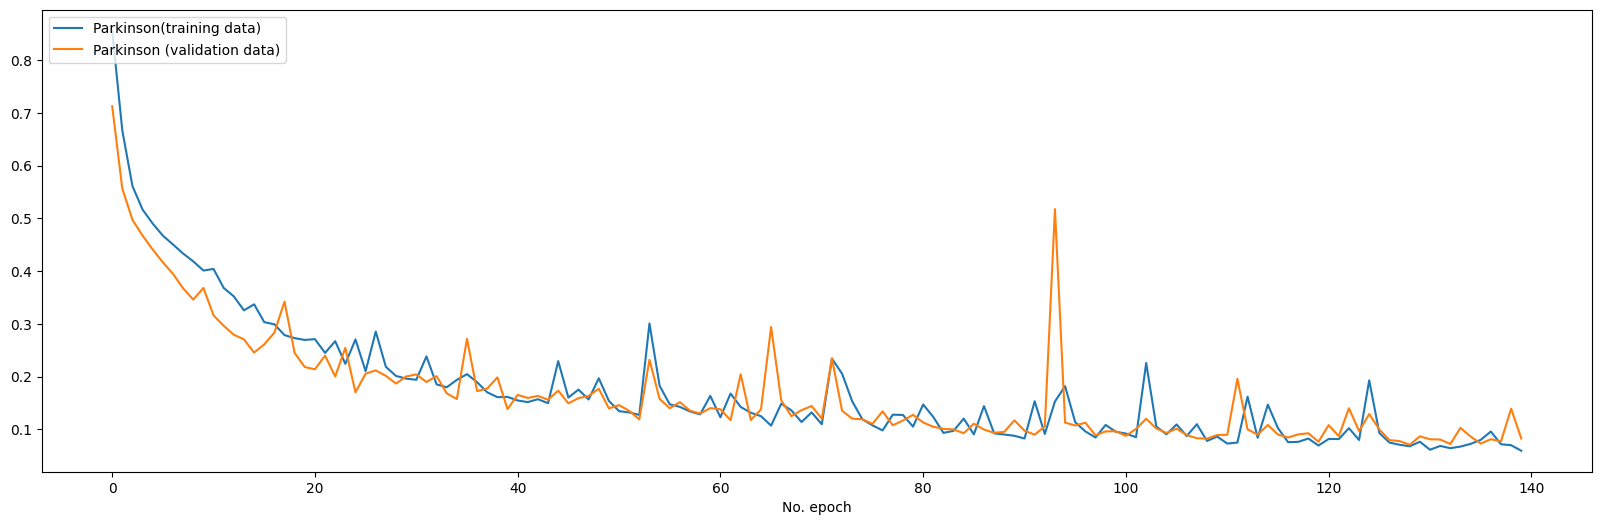

In [45]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

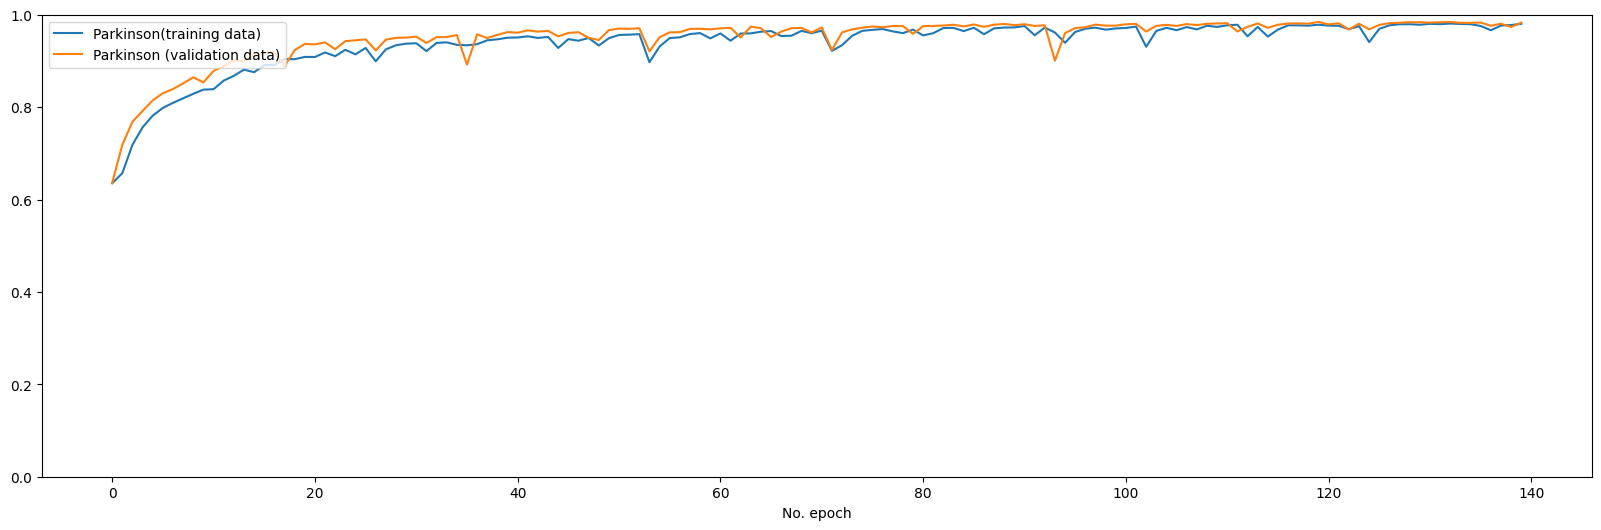

In [46]:
plt.plot(history.history['accuracy'], label='Parkinson(training data)')
plt.plot(history.history['val_accuracy'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.ylim(0,1)
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

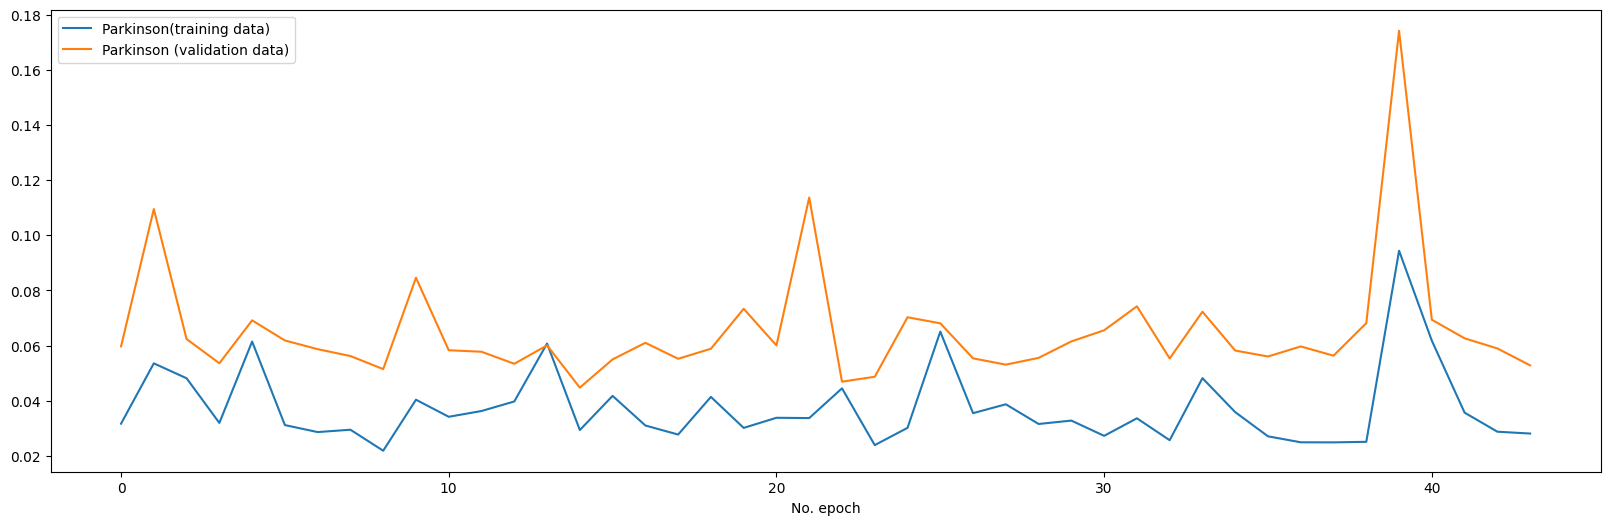

In [68]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [47]:
max(history.history['val_accuracy'])

0.9844699501991272

In [48]:
max(history.history['accuracy'])

0.9808517694473267

In [49]:
min(history.history['loss'])

0.05972537025809288

In [50]:
min(history.history['val_loss'])

0.07101456820964813

In [51]:
pdt=model.predict(X_scaled_arr_test)

In [65]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x1 )

In [69]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x1 )

In [72]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy1 = accuracy_score(Y_arr_test,classes_x1 )

In [73]:
accuracy1

0.9881172839506173

In [66]:
accuracy

0.9844135802469136

In [70]:
accuracy

0.9867283950617284

In [52]:
# classes_x=np.argmax(pdt,axis=1) 
pdt.size
classes_x = np.zeros((len(pdt)))

In [53]:
for x in range(len(pdt)):
  if(pdt[x]>0.5):
    classes_x[x]=(1)
  else:
    classes_x[x]=(0)
#   print(x,end=" ")

In [54]:
print(Y_arr_test.size)
classes_x.size

12960


12960

In [55]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x )

In [56]:
accuracy

0.9834876543209876

In [57]:
m1=tf.keras.models.load_model('./Model/model_LSTM22.v')

In [58]:
pdt=m1.predict(X_scaled_arr_test)

In [59]:
for x in range(len(pdt)):
  if(pdt[x]>0.5):
    classes_x[x]=(1)
  else:
    classes_x[x]=(0)
#   print(x,end=" ")

In [60]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x )

In [61]:
accuracy

0.9819444444444444

In [81]:
history3 = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.3,batch_size=72,shuffle=True,callbacks=[early_stopping, checkpoint],use_multiprocessing=True)

Epoch 1/500
504/504 [==============================] - 29s 58ms/step - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0405 - val_accuracy: 0.9918

Epoch 00001: val_accuracy did not improve from 0.99344
Epoch 2/500
504/504 [==============================] - 29s 58ms/step - loss: 0.0228 - accuracy: 0.9944 - val_loss: 0.0662 - val_accuracy: 0.9888

Epoch 00002: val_accuracy did not improve from 0.99344
Epoch 3/500
504/504 [==============================] - 29s 58ms/step - loss: 0.0649 - accuracy: 0.9845 - val_loss: 0.1950 - val_accuracy: 0.9619

Epoch 00003: val_accuracy did not improve from 0.99344
Epoch 4/500
504/504 [==============================] - 29s 58ms/step - loss: 0.0452 - accuracy: 0.9866 - val_loss: 0.0573 - val_accuracy: 0.9878

Epoch 00004: val_accuracy did not improve from 0.99344
Epoch 5/500
504/504 [==============================] - 29s 58ms/step - loss: 0.0272 - accuracy: 0.9916 - val_loss: 0.0515 - val_accuracy: 0.9885

Epoch 00005: val_accuracy did not improve from 0.9

In [76]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy1 = accuracy_score(Y_arr_test,classes_x1 )

In [1]:
accuracy1

NameError: name 'accuracy1' is not defined